<a href="https://colab.research.google.com/github/JamesEdMichaud/cs480student/blob/main/06/Michaud_CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

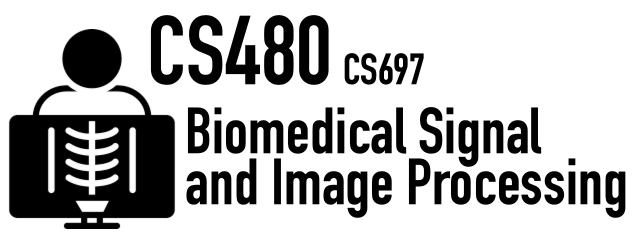
#Assignment 6

In [ ]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [ ]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [79]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [80]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-v1_kcpxu
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-v1_kcpxu
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=db201ea04805407bb472c48d6c2debaf3f0cb43d414f4159725638bc495b343b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ucookkdb/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [81]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [ ]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [ ]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [ ]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [ ]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: YOUR ANSWER
# Create a segmentation mask for noisy input images.

In [ ]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER
# That the image should be treated as single-channel (grayscale?), and that
# there are two classifications for the data (background and not-background).

In [ ]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER
#
# The powerhouses of our cells! They produce most of the chemical energy needed
# to power reactions in our cells. They appear as irregular ovoid segments,
# often darker than their surrounding tissue and sometimes with a bit of a
# border (cell wall?).

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [ ]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [ ]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [82]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        # TODO: YOUR CODE
        max = image.max()
        image /= max
        # mask[mask != 0] = 1

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.flip_left_right(image)
            mask  = tf.image.flip_left_right(mask)

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.flip_up_down(image)
            mask  = tf.image.flip_up_down(mask)

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.rot90(image)
            mask  = tf.image.rot90(mask)


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [84]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [ ]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER
# 660 * 0.7 = 462 images for training

In [85]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [86]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [87]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            #
            # TODO: YOUR CODE
            #
            #
            train,
            val,
            epochs=50,
            batch_size=10
            )

Epoch 1/50
47/47 [==============================] - 42s 845ms/step - loss: 0.6531 - categorical_crossentropy: 0.6531 - categorical_accuracy: 0.6478 - mean_iou: 0.2936 - dice_coefficient: 0.5354 - auc_4: 0.5881 - val_loss: 0.3570 - val_categorical_crossentropy: 0.3570 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3814 - val_dice_coefficient: 0.7114 - val_auc_4: 0.9849
Epoch 2/50
47/47 [==============================] - 39s 832ms/step - loss: 0.2907 - categorical_crossentropy: 0.2907 - categorical_accuracy: 0.9209 - mean_iou: 0.4544 - dice_coefficient: 0.8611 - auc_4: 0.9423 - val_loss: 0.2939 - val_categorical_crossentropy: 0.2939 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4093 - val_dice_coefficient: 0.7645 - val_auc_4: 0.9840
Epoch 3/50
47/47 [==============================] - 39s 834ms/step - loss: 0.2690 - categorical_crossentropy: 0.2690 - categorical_accuracy: 0.9210 - mean_iou: 0.4574 - dice_coefficient: 0.8647 - auc_4: 0.9483 - val_loss: 0.2662 - val_categorical

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [ ]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

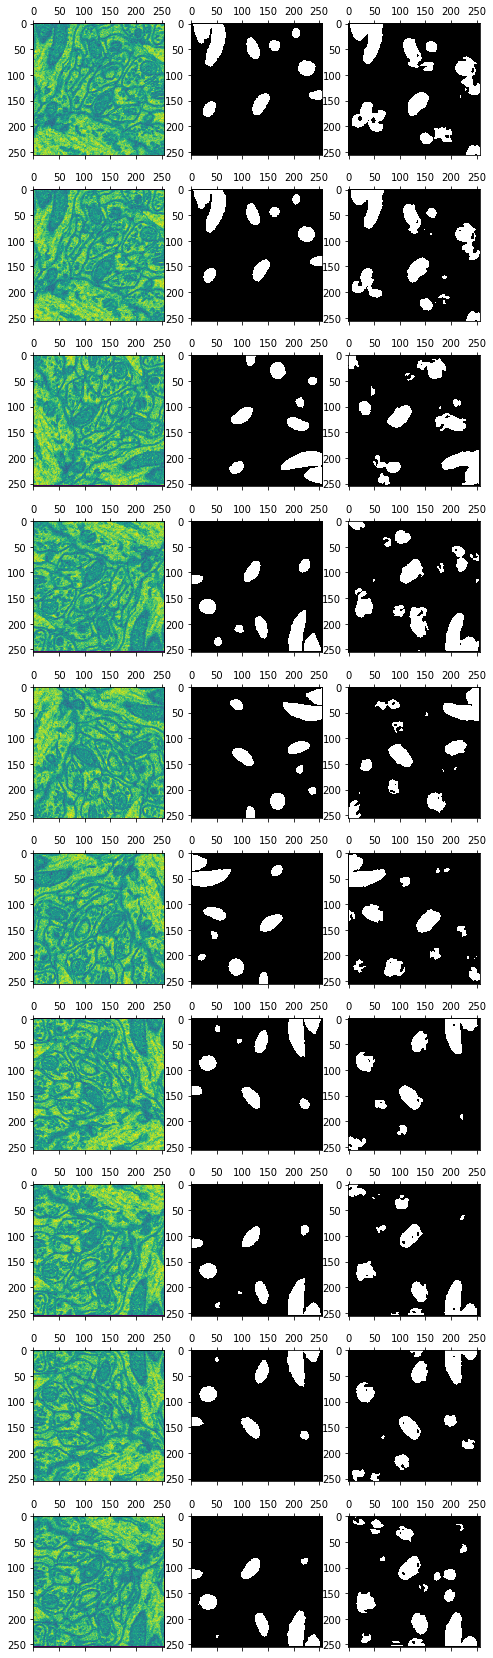

In [88]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

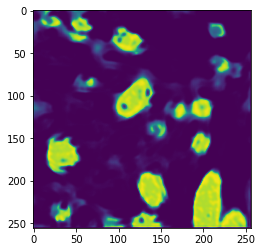

In [97]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER

# prediction[0] is used due to the shape of the variable (1, 256, 256, 2).
# Since there is only one top level index, we must use 0.

# The argmax(axis=-1) part has the effect of turning the 2-class prediction
# which may look like [0.25, 0.75] into a binary 0 or 1. In this case it would
# turn into a 1, because index 1 has the greater value. This helps produce the
# black and white images we see above instead of prediction estimates that
# range in 0..1, like this:
plt.figure()
plt.imshow(prediction[0,:,:,1])

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER

# When you consider how little code this took, the quality is quite... fair.
# However, it should certainly be improved if this is to replace manual
# segmentation, as there are a significant number of incorrect classifications.

# It may be possible to improve performance by preprocessing the images
# differently. In particular, changing the image contrast or choosing
# a larger image size (if possible) may help. I would also be curious to see
# what kind of effect adding a very slight blur might have. 

# Additional training data could of course help, but I am further curious how
# generating additional data by inverting pixel values might improve things.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [99]:
# TODO: YOUR CODE

# How nice of you to give us reading material while the model fits. :-)
# unet_model.summary()

# There are a total of 31,030,658 trainable parameters in my model.

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

In [ ]:
# TODO: YOUR ANSWER
# Encoder: 1,178,480
# Decoder: 780,053
# Total: 1,958,533 (down from 31,694,401)

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER
# This is primarily achieved through a reduction in the number of convolution
# filters used and by replacing transpose layers with bilinear upsampling layers.
# Additional speed-up was achieved by replacing a cropping step with a padding
# step.

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER
# Model utilization. 33.53% of the original U-Net model was wasted computations.
# Removing the superfluous layers resulted in nearly every calculation being
# a usefule one.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#